## Exercício: Modelo de Linguagem com auto-atenção

Este exercício é similar ao da aula passada, mas iremos agora treinar uma rede neural *com auto-atenção* para prever a próxima palavra de um texto, data as palavras anteriores como entrada.

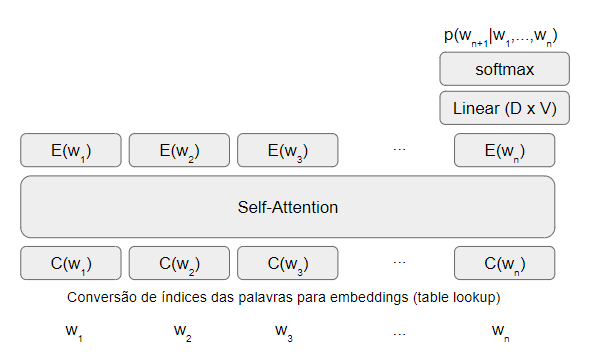

Na camada de auto-atenção, deve-se implementar (vide slide 41):
- Embeddings de posição
- Projeções lineares (WQ, WK, WV, WO)
- Camada de feed forward (2-layer MLP)

Instrucões:
- É necessário fazer duas implementações da camada de auto-atenção: uma usando laços (ineficiente, mas fácil de entender) e outra matricial (eficiente mas difícil de entender). Usar slide 41 como referência.

- Fazer um assert para garantir que o resultado das duas implementações é exatamente igual.

- No treinamento, usar apenas a implementação matricial.

# Imports

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import Counter
import random
import os
import matplotlib.pyplot as plt
from datasets import load_dataset
import time
from pathlib import Path
import datasets as hfds
import json

# Dados

## Importa dataset pré-processado

Importa artefatos gerados pelo notebook [Preparação_de_dados.ipynb](Preparação_dos_dados.ipynb), compartilhado pelo aluno **Augusto Zolet**.  
  
Ao fim desta subsessão teremos o dataset tratado, tokenizado e dividido entre treino (80%) e teste (20%).  

In [ ]:
# 14) Como carregar os artefatos a partir do Google Drive (simulando outro notebook)

# Monta o Google Drive (Colab)
try:
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive", force_remount=False)
except Exception as e:
    raise RuntimeError("Esta célula requer Google Colab para montar o Google Drive.") from e

Mounted at /content/drive


In [ ]:
# Pasta onde você salvou os artefatos na etapa anterior
GDRIVE_DIR = "/content/drive/MyDrive/Colab Notebooks/IA368HH/machado_artifacts"  # ajuste se usou outro caminho
p = Path(GDRIVE_DIR)
assert p.exists(), f"Pasta não encontrada: {p}. Verifique o caminho."

In [ ]:
def load_jsonl_as_hfds(path: Path) -> hfds.Dataset:
    """Carrega um JSONL em um HuggingFace Dataset."""
    with open(path, "r", encoding="utf-8") as f:
        records = [json.loads(line) for line in f]
    return hfds.Dataset.from_list(records)


def load_vocab(path: Path):
    with open(path, "r", encoding="utf-8") as f:
        itos = [line.rstrip("\n") for line in f]
    stoi = {tok: i for i, tok in enumerate(itos)}
    return itos, stoi

In [ ]:
# Arquivos esperados
train_path = p / "train.jsonl"
val_path = p / "val.jsonl"
vocab_path = p / "vocab.txt"
tokcfg_path = p / "tokenizer_config.json"
manifest_path = p / "manifest.json"

for path in [train_path, val_path, vocab_path, tokcfg_path, manifest_path]:
    assert path.exists(), f"Arquivo ausente: {path}"

In [ ]:
# Carrega splits
train = load_jsonl_as_hfds(train_path)
val = load_jsonl_as_hfds(val_path)

# Carrega vocabulário e configs do tokenizador
itos, stoi = load_vocab(vocab_path)  # itos[0] deve ser "<unk>"
with open(tokcfg_path, "r", encoding="utf-8") as f:
    tok_cfg = json.load(f)

# (Opcional) Lê manifest para checagens/metadata
with open(manifest_path, "r", encoding="utf-8") as f:
    manifest = json.load(f)

In [ ]:
# Resumo rápido
print(
    f"[loaded] train={len(train)} segmentos | val={len(val)} segmentos | vocab_size={len(itos)}")
print(f"[cfg] ctx={manifest.get('context_size', 'NA')} | unk='{itos[0] if itos else 'NA'}' | tokenizer flags={tok_cfg.get('strip_urls')}, {tok_cfg.get('map_numbers')}")

# Prévia de um exemplo
ex = train[0]
print("[ex/train] text:", (ex["text"][:120] +
      ("..." if len(ex["text"]) > 120 else "")))
print("[ex/train] ids[:30]:", ex["ids"][:30])

[loaded] train=140965 segmentos | val=35048 segmentos | vocab_size=2001
[cfg] ctx=5 | unk='<unk>' | tokenizer flags=True, True
[ex/train] text: e saiu, com efeito, com direção ao
[ex/train] ids[:30]: [6, 293, 1, 15, 368, 1, 15, 1335, 23]


In [ ]:
train[0]

{'text': 'e saiu, com efeito, com direção ao',
 'ids': [6, 293, 1, 15, 368, 1, 15, 1335, 23]}

In [ ]:
val[0]

{'text': 'que te parece, adelaide? a moça não respondeu.',
 'ids': [4, 215, 197, 1, 578, 29, 3, 107, 8, 225, 2]}

## Importa vocabulário já definido

Vocabulário de tamanho = 2000 (top 2000 tokens de maior ocorrência em [projetomachado](../02.%20Aula%201_2%20-%20Bengio/projetomachado/textonormalizado1000.txt)).

In [ ]:
with open(f"{GDRIVE_DIR}/vocab.txt", "r", encoding="utf-8") as f:
    vocab = {word.strip(): idx for idx, word in enumerate(f)}
print(f"Vocab size: {len(vocab)}")

Vocab size: 2001


In [ ]:
vocab

{'<unk>': 0,
 ',': 1,
 '.': 2,
 'a': 3,
 'que': 4,
 'de': 5,
 'e': 6,
 'o': 7,
 'não': 8,
 ';': 9,
 'um': 10,
 'do': 11,
 'da': 12,
 'os': 13,
 'é': 14,
 'com': 15,
 'uma': 16,
 'se': 17,
 'em': 18,
 'para': 19,
 'mas': 20,
 'as': 21,
 'era': 22,
 'ao': 23,
 'por': 24,
 'no': 25,
 'à': 26,
 'mais': 27,
 'na': 28,
 '?': 29,
 'ele': 30,
 'como': 31,
 'lhe': 32,
 'eu': 33,
 'me': 34,
 'ou': 35,
 'foi': 36,
 '!': 37,
 'dos': 38,
 '...': 39,
 'nem': 40,
 'ela': 41,
 ':': 42,
 'das': 43,
 'quando': 44,
 'sem': 45,
 'casa': 46,
 'disse': 47,
 'depois': 48,
 'já': 49,
 'há': 50,
 'tinha': 51,
 'tudo': 52,
 'ser': 53,
 'num': 54,
 'ainda': 55,
 'só': 56,
 'tempo': 57,
 'olhos': 58,
 'meu': 59,
 'nada': 60,
 'muito': 61,
 'minha': 62,
 'outra': 63,
 'd': 64,
 'outro': 65,
 'também': 66,
 'mesmo': 67,
 'dia': 68,
 'tão': 69,
 'estava': 70,
 'seu': 71,
 'porque': 72,
 'vez': 73,
 'até': 74,
 'sua': 75,
 'esta': 76,
 'assim': 77,
 'este': 78,
 'nos': 79,
 'pouco': 80,
 'agora': 81,
 'às': 82,
 'hom

## Classe do dataset

In [ ]:
# Função para criar pares (X, Y) a partir de uma lista de ids
def create_xy_pairs(dataset, context_size=5):
    X, Y = [], []
    for ex in dataset:
        ids = ex["ids"]
        # Gera pares apenas se houver tokens suficientes
        for i in range(context_size, len(ids)):
            context = ids[i-context_size:i]
            target = ids[i]
            # Remove exemplos com <unk> (ids == 0) no contexto ou target
            if 0 not in context and target != 0:
                X.append(context)
                Y.append(target)
    return X, Y


context_size = 5  # 5 palavras de entrada. O target é a próxima palavra
X_train, Y_train = create_xy_pairs(train, context_size)
X_val, Y_val = create_xy_pairs(val, context_size)

print(f"Pares treino: {len(X_train)}")
print(f"Pares validação: {len(X_val)}")

Pares treino: 581125
Pares validação: 143086


In [ ]:
# os pares são apenas dos ids
X_train[0], Y_train[0]

([6, 293, 1, 15, 368], 1)

In [ ]:
from torch.utils.data import Dataset, DataLoader


class MachadoDataset(Dataset):
    """Dataset para modelagem de linguagem com contexto.

    Attributes:
        X = contexts: lista de contextos (N, context_size)
        Y = targets: lista de alvos (N,)
        context_size (int): Tamanho do contexto (janela de tokens)
    """

    def __init__(self, X, Y, context_size=5):
        """Inicializa o dataset.

        Args:
            contexts: Lista ou tensor de contextos (cada contexto tem context_size tokens)
            targets: Lista ou tensor de tokens alvo
            context_size: Tamanho do contexto (default: 5)
        """
        # Validações
        assert len(X) == len(Y), "Número de contextos e alvos deve ser igual"
        if isinstance(X, list):
            assert all(len(ctx) == context_size for ctx in X), f"Todos os contextos devem ter tamanho {context_size}"

        # Converte para tensores
        self.X = torch.tensor([[x for x in ctx] for ctx in X], dtype=torch.long)
        self.Y = torch.tensor([y for y in Y], dtype=torch.long)

        self.context_size = context_size

    def __len__(self):
        """Retorna o número total de exemplos."""
        return len(self.X)

    def __getitem__(self, idx):
        """Retorna um par (contexto, alvo).
        Args:
            idx: Índice do exemplo
        Returns:
            tuple: (context_tensor, target_tensor)
        """
        return self.X[idx], self.Y[idx]

In [ ]:
train_data = MachadoDataset(X_train, Y_train, context_size=context_size)
val_data = MachadoDataset(X_val, Y_val, context_size=context_size)

## Inicia DataLoaders

In [ ]:
batch_size = 256       # tamanho do batch
embed_dim_glob = 128   # dimensao do vetor de embedding (m)
hidden_dim_glob = 512  # dimensao da camada oculta (h)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
sample = next(iter(train_loader))

# Model

## Criando camadas de auto-atenção

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F


class SelfAttentionLoop(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

        # Projeções lineares Q, K, V
        self.WQ = nn.Linear(d_model, d_model)
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)

        self.WO = nn.Linear(d_model, d_model)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        B, L, D = x.shape

        Q = self.WQ(x)  # (B, L, D) (batch, seq_len, d_model)
        K = self.WK(x)  # (B, L, D) (batch, seq_len, d_model)
        V = self.WV(x)  # (B, L, D) (batch, seq_len, d_model)

        outputs = []

        # Loop para calcular atenção
        for i in range(L):
            q_i = Q[:, i, :].unsqueeze(1)   # [B, D]

            # Similaridade com todos os K
            scores = torch.bmm(q_i, K.transpose(1, 2))  # [B, 1, L]
            scores = scores.squeeze(1) / (D ** 0.5)     # [B, L]

            # Softmax para obter pesos
            attn_weights = F.softmax(scores, dim=-1)  # [B, L]

            # Combinação ponderada dos valores V
            context = torch.bmm(attn_weights.unsqueeze(1), V)  # [B, 1, D]
            outputs.append(context)

        # Concatena todas as saídas
        outputs = torch.cat(outputs, dim=1)  # [B, L, D]
        outputs = self.WO(outputs)
        return outputs

In [ ]:
class SelfAttentionMatrix(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0, "d_model deve ser divisível por n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        # Matrizes de projeção Q, K, V
        self.WQ = nn.Linear(d_model, d_model)
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)

        # Camada final para recombinar heads
        self.WO = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        # x: [batch_size, seq_len, d_model]
        B, L, D = x.shape

        # Projeções lineares
        Q = self.WQ(x)  # [B, L, D]
        K = self.WK(x)  # [B, L, D]
        V = self.WV(x)  # [B, L, D]

        # Divide em múltiplos heads
        Q = Q.view(B, L, self.n_heads, self.d_head).transpose(1, 2)  # [B, heads, L, d_head]
        K = K.view(B, L, self.n_heads, self.d_head).transpose(1, 2)
        V = V.view(B, L, self.n_heads, self.d_head).transpose(1, 2)

        # Atenção escalada: QK^T / sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / \
            (self.d_head ** 0.5)  # [B, heads, L, L]

        # Aplica máscara (opcional, usada no decoder)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn = F.softmax(scores, dim=-1)  # pesos de atenção
        out = torch.matmul(attn, V)       # [B, heads, L, d_k]

        # Junta os heads de volta
        out = out.transpose(1, 2).contiguous().view(B, L, D)  # [B, L, D]

        # Projeção final
        return self.WO(out)

## Definindo modelo

In [ ]:
class LanguageModelAttention(nn.Module):
    def __init__(
        self,
        vocab_size=2000 + 1,  # top 2000 + 1 unk
        embedding_dim=128,   # embedding_dim = d_model
        hidden_dim=256,
        context_size=5,
        n_heads=1,
        version="matrix"
    ):
        """
        Args:
            vocab_size: Tamanho do vocabulário
            embedding_dim: Dimensionalidade dos embeddings
            hidden_dim: Dimensionalidade da camada oculta
            context_size: Tamanho do contexto (número de palavras de entrada)
            n_heads: Número de cabeças de atenção
            version: Versão da atenção (loop=loop ou matriz=matrix)
        """
        super(LanguageModelAttention, self).__init__()

        # Camada de embedding
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Camada de positional embedding
        self.embeddings_pos = nn.Embedding(context_size, embedding_dim)

        # Dropout após embeddings (ref artigo)
        self.dropout = nn.Dropout(0.1)

        # Camada de atenção
        if version == "loop":
            self.attention = SelfAttentionLoop(embedding_dim)
        elif version == "matrix":
            self.attention = SelfAttentionMatrix(embedding_dim, n_heads)
        else:
            raise ValueError("Versão de atenção não suportada")

        # 2 Camadas feed-forward
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )

        # Camada de normalização
        self.layer_norm = nn.LayerNorm(embedding_dim)

        # Camada de saída
        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        # x tem shape (batch_size, context_size)
        B, L = x.shape  # B = batch_size, L = context_size
        positions = torch.arange(L, device=x.device).unsqueeze(
            0).expand(B, L)  # definindo posições

        # embedding + posições
        # [B, L, D] (batch, context_size, embedding_dim)
        x = self.embeddings(x) + self.embeddings_pos(positions)

        # dropout pos embedding
        x = self.dropout(x)

        # self-attention (será [B, L, D])
        x = self.attention(x)

        # feed-forward (ainda [B, L, D])
        x = self.feed_forward(x)

        # layer normalization
        x = self.layer_norm(x)

        # Camada de saída (será [B, L, vocab_size])
        out = self.output(x)

        return out

In [ ]:
model_matrix = LanguageModelAttention(
    vocab_size=2000 + 1,
    embedding_dim=128,
    hidden_dim=256,
    context_size=5,
    n_heads=1,
    version="matrix"
)

model_loop = LanguageModelAttention(
    vocab_size=2000 + 1,
    embedding_dim=128,
    hidden_dim=256,
    context_size=5,
    n_heads=1,
    version="loop"
)

# === copiar pesos de um para o outro ===
model_matrix.load_state_dict(model_loop.state_dict())

<All keys matched successfully>

In [ ]:
# sample = next(iter(train_loader))
input = sample[0]
target = sample[1]

In [ ]:
output_matrix = model_matrix(input)
output_loop = model_loop(input)
# Verifica se os resultados são próximos
are_equal = torch.allclose(output_matrix, output_loop, atol=1e-6)
are_equal

False

In [ ]:
print("Saída loop:", output_loop.shape)
print("Saída matrix:", output_matrix.shape)

Saída loop: torch.Size([256, 5, 2001])
Saída matrix: torch.Size([256, 5, 2001])


In [ ]:
# diferença média absoluta
diff = (output_loop - output_matrix).abs().mean().item()
print("Diferença média:", diff)

Diferença média: 0.1826811134815216


In [ ]:
# verificando somente nas camadas de atenção
# fiz isso, pois vi que um dos motivos para as redes inteiras não estarem coincidindo poderia ser ocasionado pelo dropout
torch.manual_seed(42)

B, L, D = 2, 5, 16
x = torch.randn(B, L, D)

loop = SelfAttentionLoop(D)
matrix = SelfAttentionMatrix(D, n_heads=1)

# copiar pesos
matrix.load_state_dict(loop.state_dict())

out_loop = loop(x)
out_matrix = matrix(x)

print("Shapes:", out_loop.shape, out_matrix.shape)
print("Diferença média:", (out_loop - out_matrix).abs().mean().item())

# Verifica se os resultados são próximos
are_equal = torch.allclose(out_loop, out_matrix, atol=1e-6)
print("São iguais?", are_equal)

Shapes: torch.Size([2, 5, 16]) torch.Size([2, 5, 16])
Diferença média: 1.435400953653243e-08
São iguais? True


In [ ]:
output_matrix.argmax(dim=1)

tensor([[1, 4, 3,  ..., 3, 3, 3],
        [2, 2, 1,  ..., 4, 1, 2],
        [2, 0, 1,  ..., 4, 1, 3],
        ...,
        [3, 3, 1,  ..., 1, 1, 1],
        [3, 2, 4,  ..., 1, 4, 1],
        [4, 2, 1,  ..., 3, 2, 3]])

In [ ]:
target

tensor([   2,    9,   10,  864,    3, 1573,  128,  607,  299,   47,    1,    1,
          51,    1,    4,   99,  598,   30,   24,   22,   79,   14, 1818,  234,
           6,    5,   18,   32,    3,   10, 1046,    9,   46,    6,  515,   19,
          49,   16,   46,  512,   10,   14,  190, 1183,  995,  182,   32,    8,
           1,   26,   14,   35,    5,    7,   14, 1298,   41,   24,   36,    7,
           7,   26,   17,    1,  202,    4, 1849,  608,   55,   22,   18,  795,
           2,    2,   38,  276,  381,  260,  902,   83,   43,   15,    3,  240,
          35,  280,    1,   22,   12,   62,   73,   49,  117,   30,   10,    1,
          22,   22,    3,    5,  230,  342,    2,   27,    5,   12,    4, 1619,
           3,  391,  116,    8,  859,  255,   30,  129,    1,   12,  845,   36,
          31,  586, 1417,   19,    8,  346,    8,   15,   96,  191,  610,  211,
          27,  116,    3,    1,  135,   96,  621,   15,    7,  113,   14,  628,
          10,    2,    5,  208,    1, 12

## Training

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")
#
# print(device)

mps


In [ ]:
# define finçao de treinamento e validação
def train_batch(model, X, Y, optimizer, criterion, device):
    model.train()

    # X, Y = data
    X, Y = X.to(device), Y.to(device)

    # forward pass
    output = model(X)
    # ajustando dimensoes, pois saida terá shape [batch_size, context_size, vocab_size]
    output = output[:, -1, :]  # [B, V]
    loss = criterion(output, Y)  # Y com shape [B]
    # loss = criterion(output, Y)

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


@torch.no_grad()
def validate_batch(model, X, Y, criterion, device):
    model.eval()

    # X, Y = data
    X, Y = X.to(device), Y.to(device)

    output = model(X)  # [B, L, V]
    output = output[:, -1, :]  # [B, V]
    loss = criterion(output, Y)  # Y com shape [B]

    return loss.item()

In [ ]:
model_matrix.output.out_features

2001

In [ ]:
# define função de treinamento do modelo
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, patience=3):
    # Validação inicial
    vocab_size = model.output.out_features

    def validate_indices(loader, split_name):
        for batch_idx, (X, Y) in enumerate(loader):
            if X.max() >= vocab_size:
                raise ValueError(
                    f"Batch {batch_idx} em {split_name} tem índice {X.max()} >= vocab_size {vocab_size}")
            if Y.max() >= vocab_size:
                raise ValueError(
                    f"Batch {batch_idx} em {split_name} tem target {Y.max()} >= vocab_size {vocab_size}")

    print("Validando índices...")
    validate_indices(train_loader, "train")
    validate_indices(val_loader, "val")
    print("Validação ok!")

    # treinamento
    model.to(device)

    losses_train = []  # losses for plotting
    losses_val = []  # losses for plotting

    perplexities_train = []  # perplexities for plotting
    perplexities_val = []  # perplexities for plotting

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        N = len(train_loader)  # number of batches
        train_loss = 0.0
        val_loss = 0.0
        start_time = time.time()

        model.train()
        for batch in train_loader:
            X, Y = batch  # Unpack the batch first
            batch_loss = train_batch(model, X, Y, optimizer, criterion, device)
            train_loss += batch_loss

        epoch_loss = train_loss / N  # average loss for the epoch
        losses_train.append(epoch_loss)
        # perplexity is the exponential of the loss
        epoch_perplexity = np.exp(epoch_loss)
        perplexities_train.append(epoch_perplexity)

        epoch_duration = time.time() - start_time

        N = len(val_loader)  # number of batches
        model.eval()
        for batch in val_loader:
            X, Y = batch  # Unpack the batch first
            batch_loss = validate_batch(model, X, Y, criterion, device)
            val_loss += batch_loss

        epoch_loss_val = val_loss / N  # average loss for the epoch
        losses_val.append(epoch_loss_val)
        # perplexity is the exponential of the loss
        epoch_perplexity_val = np.exp(epoch_loss_val)
        perplexities_val.append(epoch_perplexity_val)

        print(f'Epoch [{epoch+1}/{epochs}] | ',
              f'Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_loss_val:.4f} | ',
              f'Train Perplexity: {epoch_perplexity:.4f} | Val Perplexity: {epoch_perplexity_val:.4f} | ',
              f'Time: {epoch_duration:.2f}s')

        # Early stopping
        if epoch_loss_val < best_val_loss:
            best_val_loss = epoch_loss_val
            patience_counter = 0
            # Se quiser salvar o melhor modelo:
            # torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(
                    f"Early stopping em {epoch+1} épocas! Melhor val_loss: {best_val_loss:.4f}")
                break

    return losses_train, losses_val, perplexities_train, perplexities_val, model

In [ ]:
model_matrix = LanguageModelAttention(
    vocab_size=2000 + 1,
    embedding_dim=128,
    hidden_dim=256,
    context_size=5,
    n_heads=1,
    version="matrix"
).to(device)

epochs = 15
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_matrix.parameters(), lr=lr)

# Calcula a loss e perplexidade iniciais no conjunto de treinamento
model_matrix.eval()
train_loss = 0.0
N = len(train_loader)
for X, Y in train_loader:
    X, Y = X.to(device), Y.to(device)
    output = model_matrix(X)
    output = output[:, -1, :]  # [B, V]
    loss = criterion(output, Y)
    train_loss += loss.item()
train_loss /= N
train_perplexity = np.exp(train_loss)
print(
    f"Train loss inicial: {train_loss:.4f} | Perplexidade inicial: {train_perplexity:.4f}")

Train loss inicial: 7.7904 | Perplexidade inicial: 2417.3634


In [ ]:
losses_train, losses_val, perplexities_train, perplexities_val, model = train_model(
    model=model_matrix,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    patience=3
)

# na minha maquina local demorou ~30s por época em cpu
# demorou ~23s na mps do mac
# demorou ~13s com T4 no colab
# testei, com 5, 10 e 15 épocas, sempre foi melhorando sem atingir o early stop
# não testei com mais, pois pareceu dar uma estabilizada no ganho

Validando índices...
Validação ok!
Epoch [1/15] |  Train Loss: 4.8816 | Val Loss: 4.6156 |  Train Perplexity: 131.8450 | Val Perplexity: 101.0520 |  Time: 13.52s
Epoch [2/15] |  Train Loss: 4.5512 | Val Loss: 4.4882 |  Train Perplexity: 94.7480 | Val Perplexity: 88.9572 |  Time: 13.07s
Epoch [3/15] |  Train Loss: 4.4524 | Val Loss: 4.4309 |  Train Perplexity: 85.8366 | Val Perplexity: 84.0069 |  Time: 13.36s
Epoch [4/15] |  Train Loss: 4.3793 | Val Loss: 4.3693 |  Train Perplexity: 79.7812 | Val Perplexity: 78.9882 |  Time: 13.26s
Epoch [5/15] |  Train Loss: 4.3217 | Val Loss: 4.3201 |  Train Perplexity: 75.3195 | Val Perplexity: 75.1938 |  Time: 17.12s
Epoch [6/15] |  Train Loss: 4.2668 | Val Loss: 4.2794 |  Train Perplexity: 71.2911 | Val Perplexity: 72.2000 |  Time: 18.23s
Epoch [7/15] |  Train Loss: 4.2183 | Val Loss: 4.2481 |  Train Perplexity: 67.9184 | Val Perplexity: 69.9750 |  Time: 15.03s
Epoch [8/15] |  Train Loss: 4.1726 | Val Loss: 4.2127 |  Train Perplexity: 64.8814 | Val

## Avaliação

In [ ]:
def plot_losses_and_perplexity(losses_train, losses_val, perplexities_train, perplexities_val):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].plot(losses_train, label='Train Loss')
    ax[0].plot(losses_val, label='Val Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train and Val Loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(perplexities_train, label='Train Perplexity')
    ax[1].plot(perplexities_val, label='Val Perplexity')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Perplexity')
    ax[1].set_title('Train and Val Perplexity')
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()

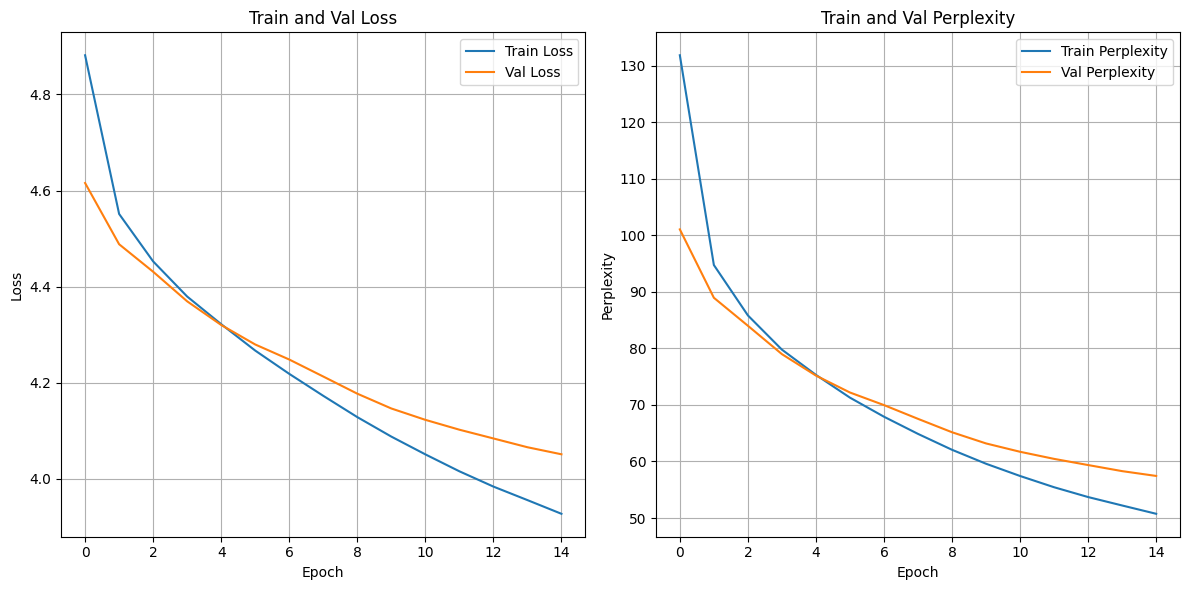

In [ ]:
plot_losses_and_perplexity(losses_train, losses_val, perplexities_train,
                           perplexities_val)  # plot losses and perplexity

## Exemplo de uso

In [ ]:
def generate_text(model, vocab, seed_text, max_length=20, device='cpu', context_size=5):
    """
    Gera texto a partir de um modelo de linguagem treinado.

    Args:
        model: modelo treinado (nn.Module)
        vocab: dicionário {token: id}
        seed_text: texto inicial (str)
        max_length: número máximo de palavras a gerar
        device: cpu ou cuda
        context_size: tamanho do contexto usado pelo modelo

    Returns:
        Texto gerado (str)
    """
    model.eval()
    model.to(device)
    id_to_token = {idx: tok for tok, idx in vocab.items()}

    # Tokeniza e converte seed_text para ids
    tokens = seed_text.strip().lower().split()
    context = [vocab.get(token, 0) for token in tokens[-context_size:]]

    # Preenche contexto se necessário
    if len(context) < context_size:
        context = [0] * (context_size - len(context)) + context

    generated = context.copy()

    for _ in range(max_length):
        x = torch.tensor([context], dtype=torch.long, device=device)
        with torch.no_grad():
            logits = model(x)
            # adaptado para o modelo de matriz de atenção
            # agora a saída é uma matriz de dimensão (batch_size, seq_len, vocab_size)
            # então precisamos pegar a última posição da sequência
            logits = logits[:, -1, :]
        next_id = torch.argmax(logits, dim=-1).item()
        generated.append(next_id)
        context = generated[-context_size:]

    # Converte ids para tokens, ignora <unk> se quiser
    result = [id_to_token.get(idx, '<unk>')
              for idx in generated if idx in id_to_token]
    return ' '.join(result)

In [ ]:
context = 5
max_length = 9
text = "Era uma dia belo de sol"
generate_text(model_matrix, vocab, text, max_length, device)

'uma dia belo de sol , e não se fosse a que lhe dava'

In [ ]:
text = "este é um texto gerado artificialmente"
generate_text(model_matrix, vocab, text, max_length, device)

'é um texto <unk> <unk> , e não era preciso que o pai de'

In [ ]:
text = "E se em cada caso"
generate_text(model_matrix, vocab, text, max_length, device)

'e se em cada caso que não era a mesma coisa . a mãe'

In [ ]:
text = "na vida nada se perde"
generate_text(model_matrix, vocab, text, max_length, device)

'na vida nada se perde o que era um homem de vinte e sete'

In [ ]:
text = "queria saber o segredo da vida"
generate_text(model_matrix, vocab, text, max_length, device)

'saber o segredo da vida , e o que era um homem de vinte'

In [ ]:
text = "parece que queres rimar"
generate_text(model_matrix, vocab, text, max_length, device)

'<unk> parece que queres <unk> ? perguntou o velho . a mãe , que'